In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from afqinsight.nn.utils import prep_fa_dataset, reconstruction_loss, vae_loss, kl_divergence_loss, prep_first_tract_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
import pandas as pd
import seaborn as sns
from afqinsight.nn.pt_models import Conv1DVariationalAutoencoder, Conv1DAutoencoder



/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# FIRST TRACT DATASET
# VARIATIONAL 
# CONVOLUTIONAL AUTOENCODER
# TESTING LATENT AND DROPOUT SIMULTATENTOUSLY 

In [3]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [4]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [5]:
torch_dataset, first_tract_train_loader, first_tract_test_loader, first_tract_val_loader = prep_first_tract_data(
    dataset, batch_size=64
)

In [6]:
def train_variational_autoencoder_widescope(model, train_data, val_data, epochs=500, lr=0.001, kl_weight=0.001):
    """
    Training loop for variational autoencoder with KL annealing
    """
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    train_kl_per_epoch = []
    val_kl_per_epoch = []
    train_recon_per_epoch = []
    val_recon_per_epoch = []
    
    best_val_rmse = float('inf')  # Track the best (lowest) validation RMSE
    best_model_state = None  # Save the best model state

    #lets try KL annealing
    beta_start = 0.0
    beta_end = 1.0
    slope = (beta_end - beta_start) / epochs
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0
        running_rmse = 0
        running_kl = 0
        items = 0
        running_recon_loss = 0 
        beta = beta_start + slope * epoch
        
        for x, _ in train_data:
            batch_size = x.size(0)
            tract_data = x.to(device)
            
            opt.zero_grad()
            
            # Forward pass returns reconstructed x, mean and logvar
            x_hat, mean, logvar = model(tract_data)
            
            # Compute loss with KL divergence
            loss, recon_loss, kl_loss = vae_loss(tract_data, x_hat, mean, logvar, beta, reduction="sum")
            #recon loss here is the sum of the MSE
            #loss is the sum of the KL and the recon loss
            #kl loss is the sum of the KL
            #none are normalized yet 

            # Calculate RMSE (primarily for logging)
            batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
            
            loss.backward()
            opt.step()
              
            #increasing by batch size
            items += batch_size
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * batch_size  # Weighted sum
            running_kl += kl_loss.item() # Average KL per item
            running_recon_loss += recon_loss.item() # Average recon loss per item
        
        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        avg_train_kl = running_kl / items 
        avg_train_recon_loss = running_recon_loss / items
        train_rmse_per_epoch.append(avg_train_rmse)
        train_kl_per_epoch.append(avg_train_kl)
        train_recon_per_epoch.append(avg_train_recon_loss)

        # Validation
        model.eval()
        val_rmse = 0
        val_kl = 0
        val_items = 0
        val_recon_loss = 0
        
        with torch.no_grad():
            for x, *_ in val_data:
                batch_size = x.size(0)
                tract_data = x.to(device)
                print("tract_data", tract_data.size())

                x_hat, mean, logvar = model(tract_data)
                
                val_loss, val_recon_loss, val_kl_loss = vae_loss(tract_data, x_hat, mean, logvar, beta, reduction="sum")
                
                batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                val_items += batch_size
                val_loss += val_loss.item()
                val_rmse += batch_val_rmse.item() * tract_data.size(0)
                val_kl += val_kl_loss.item()
                val_recon_loss += val_recon_loss.item()
        
        avg_val_recon_loss = val_recon_loss / val_items
        avg_val_rmse = val_rmse / val_items
        avg_val_kl = val_kl / val_items
        val_rmse_per_epoch.append(avg_val_rmse)
        val_kl_per_epoch.append(avg_val_kl)
        val_recon_per_epoch.append(avg_val_recon_loss)
        
        # Check and save the best model state if current validation loss is lower
        if avg_val_rmse < best_val_rmse:
            print("Saving best model state with RMSE:", avg_val_rmse)
            best_val_rmse = avg_val_rmse
            best_model_state = model.state_dict().copy()  # Make a copy to ensure it's preserved
        
        print(f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}, KL: {avg_train_kl:.4f}," ,
              f"Recon Loss (Train): {avg_train_recon_loss:.4f}, Recon Loss (Val): {avg_val_recon_loss:.4f}")
    
    # Load the best model state back into the model
    model.load_state_dict(best_model_state)
    
    return {
        "train_rmse_per_epoch": train_rmse_per_epoch,
        "val_rmse_per_epoch": val_rmse_per_epoch,
        "train_kl_per_epoch": train_kl_per_epoch,
        "val_kl_per_epoch": val_kl_per_epoch,
        "train_recon_per_epoch": train_recon_per_epoch,
        "val_recon_per_epoch": val_recon_per_epoch,
        "best_val_rmse": best_val_rmse,
    }

In [8]:
latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
models = {}
results = {}

for dropout in dropout_values:
    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim} and Dropout: {dropout}")
        
        # Initialize a new autoencoder for each latent dimension
        test_model = Conv1DVariationalAutoencoder(latent_dims=latent_dim, dropout=dropout).to(device)
        
        # Train the model 
        training_results = train_variational_autoencoder_widescope(test_model, first_tract_train_loader, first_tract_val_loader, 100, 0.001)
        
        # Store both the model and results
        models[latent_dim, dropout] = test_model
        results[latent_dim, dropout] = training_results
        
        print(f"Completed training for latent_dim={latent_dim}, Best Val RMSE: {training_results['best_val_rmse']:.4f}")


Training Autoencoder with Latent Dimension: 2 and Dropout: 0.0
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([64, 64, 13])
after con torch.Size([42, 64, 13])
tract_data torch.Size([64, 1, 100])
after con torch.Size([64, 64, 13])
tract_data torch.Size([64, 1, 100])
after con torch.Size([64, 64, 13])
tract_data torch.Size([64, 1, 100])
after con torch.Size([64, 64, 13])
tract_data torch.Size([64, 1, 100])
after con torch.Size([6

Latent Dim: 2, Dropout: 0.0
Latent Dim: 2, Dropout: 0.1
Latent Dim: 2, Dropout: 0.5
Latent Dim: 4, Dropout: 0.0
Latent Dim: 4, Dropout: 0.1
Latent Dim: 4, Dropout: 0.5
Latent Dim: 8, Dropout: 0.0
Latent Dim: 8, Dropout: 0.1
Latent Dim: 8, Dropout: 0.5
Latent Dim: 16, Dropout: 0.0
Latent Dim: 16, Dropout: 0.1
Latent Dim: 16, Dropout: 0.5
Latent Dim: 32, Dropout: 0.0
Latent Dim: 32, Dropout: 0.1
Latent Dim: 32, Dropout: 0.5
Latent Dim: 64, Dropout: 0.0
Latent Dim: 64, Dropout: 0.1
Latent Dim: 64, Dropout: 0.5
Latent Dim: 100, Dropout: 0.0
Latent Dim: 100, Dropout: 0.1
Latent Dim: 100, Dropout: 0.5


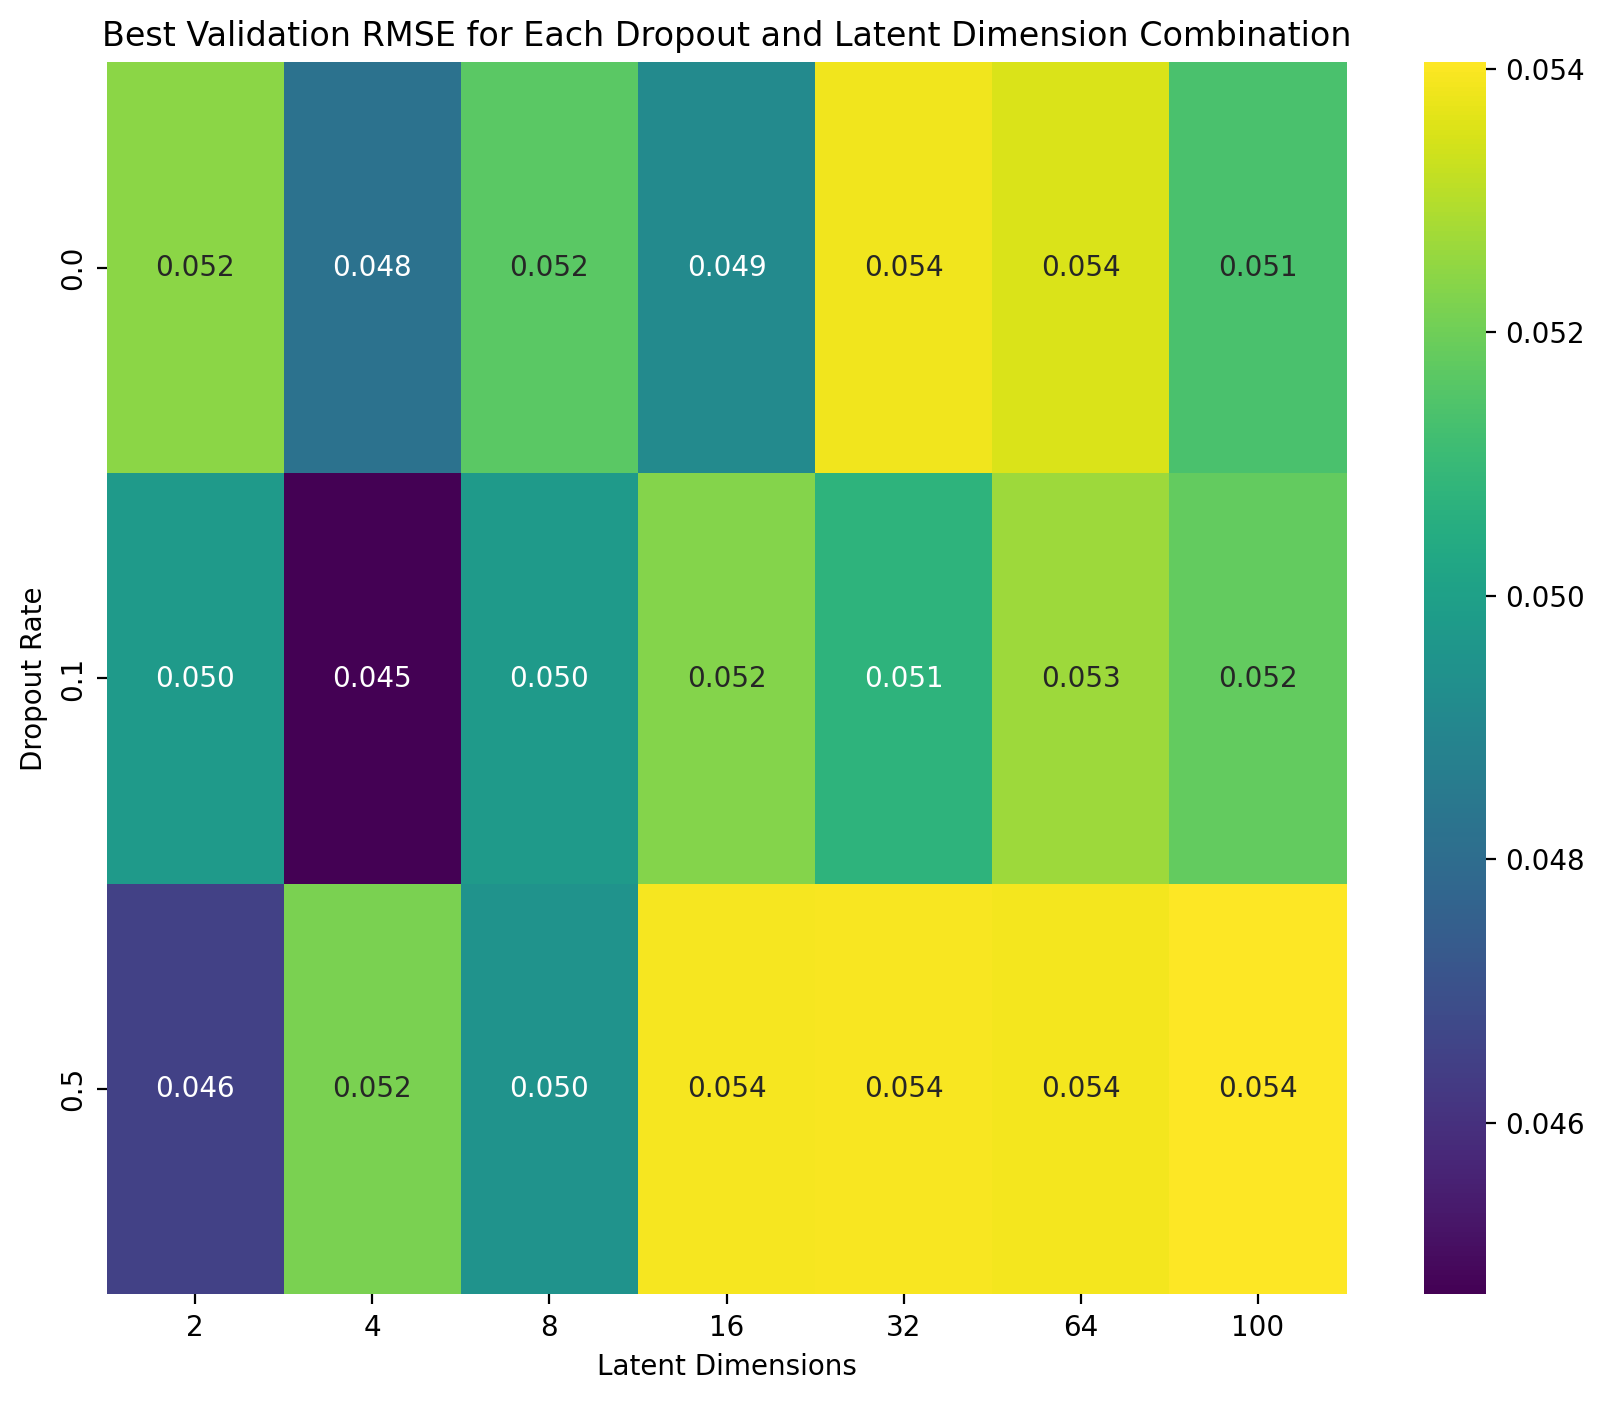

In [10]:
# Create a DataFrame with rows for dropout and columns for latent_dims
latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
df_best_val = pd.DataFrame(index=dropout_values, columns=latent_dims)

# Populate the DataFrame with the best validation RMSE values
for latent_dim in latent_dims:
    for dropout in dropout_values:
        print(f"Latent Dim: {latent_dim}, Dropout: {dropout}")  
        key = (latent_dim, dropout)
        if key in results:
            best_val_loss = results[key]["best_val_rmse"]
            df_best_val.loc[dropout, latent_dim] = best_val_loss
        else:
            print(f"Key {key} not found in results.")
            # Handle missing key, e.g., set a default value
            df_best_val.loc[dropout, latent_dim] = np.nan  # or any other default


# Convert the values to floats (if they aren't already)
df_best_val = df_best_val.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_best_val, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("Latent Dimensions")
plt.ylabel("Dropout Rate")
plt.title("Best Validation RMSE for Each Dropout and Latent Dimension Combination")
plt.show()


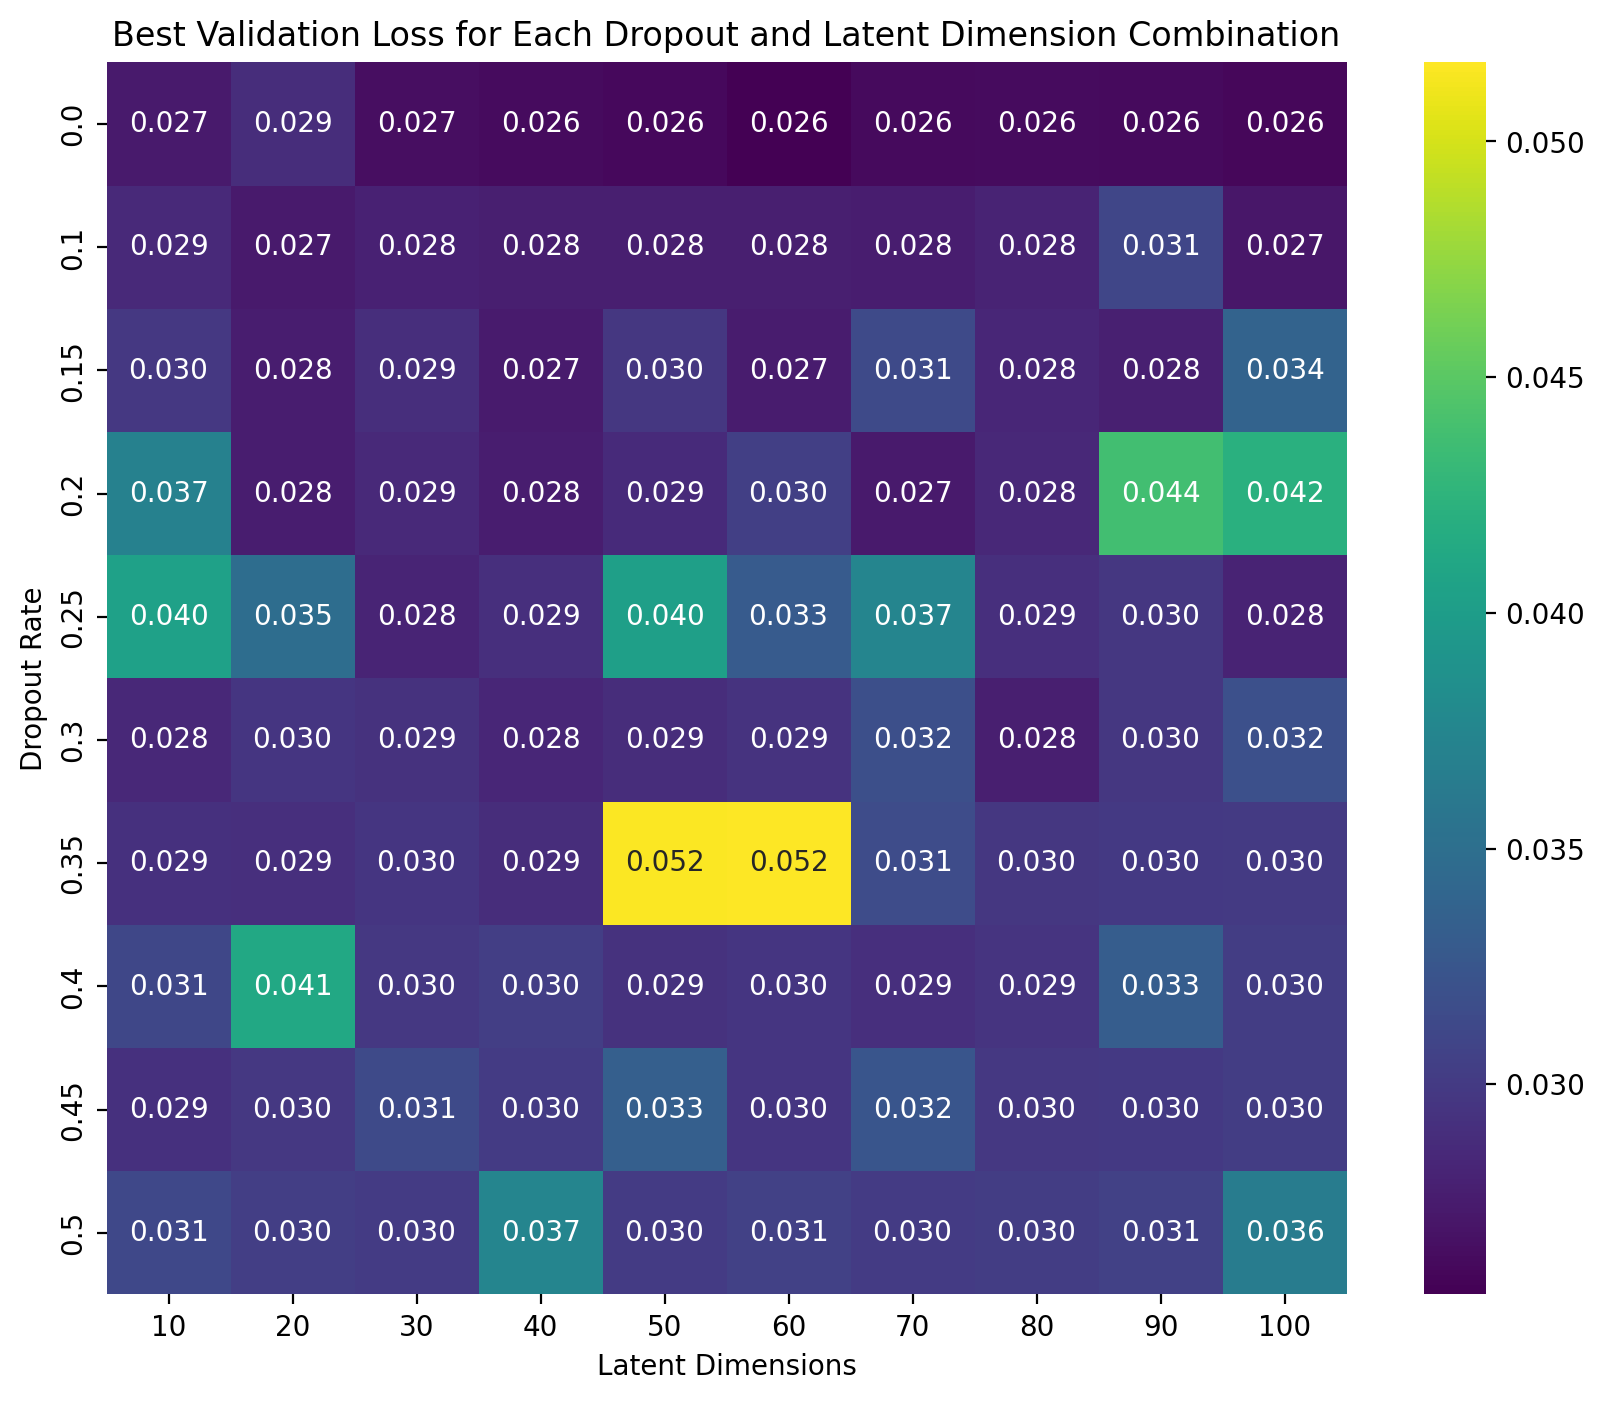

In [ ]:
df_best_val = pd.DataFrame(index=dropout_values, columns=latent_dims)

# Populate the DataFrame with the best validation losses
for (dropout, latent_dim), best_val_loss in best_val_results.items():
    df_best_val.loc[dropout, latent_dim] = best_val_loss

# Convert the values to floats (if not already)
df_best_val = df_best_val.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_best_val, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("Latent Dimensions")
plt.ylabel("Dropout Rate")
plt.title("Best Validation Loss for Each Dropout and Latent Dimension Combination")
plt.show()

In [ ]:
# Plot best validation RMSE for each dropout value
plt.figure(figsize=(10, 6))
dropout_keys = sorted(best_val_results.keys())
best_vals = [best_val_results[d] for d in dropout_keys]
plt.plot(dropout_keys, best_vals, marker='o')
plt.xlabel("Dropout")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Dropout")
plt.grid()
plt.show()



In [ ]:
# Plot 1: Training RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Plot 2: Validation RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Plot 3: Both Training and Validation RMSE
plt.figure(figsize=(18, 8))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        linestyle="--",
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs. Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()